In [0]:
"""REF Bayesian Methods for Hackers 
In this notebook we modified some part of original code for learning how MCMC algorithm work
"""

In [0]:
"""
In short, MCMC outperform the general monte carlo because even we set the average and standard deviation randomly, MCMC still be able to find the similar real average and sd but MCMC needs sufficient sample.
"""

In [0]:
#@title Imports and Global Variables  { display-mode: "form" }
"""
The book uses a custom matplotlibrc file, which provides the unique styles for
matplotlib plots. If executing this book, and you wish to use the book's
styling, provided are two options:
    1. Overwrite your own matplotlibrc file with the rc-file provided in the
       book's styles/ dir. See http://matplotlib.org/users/customizing.html
    2. Also in the styles is  bmh_matplotlibrc.json file. This can be used to
       update the styles in only this notebook. Try running the following code:

        import json
        s = json.load(open("../styles/bmh_matplotlibrc.json"))
        matplotlib.rcParams.update(s)
"""
!pip3 install -q praw
!pip3 install -q pandas_datareader
!pip3 install -q wget
from __future__ import absolute_import, division, print_function

#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
import pandas_datareader.data as web
#%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res
import pandas as pd
import tensorflow as tf
tfe = tf.contrib.eager

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
    try:
        tf.enable_eager_execution()
    except:
        pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.
   
    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options()
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()

In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=15y6y-xZ2fnEgbRf2qLKqLriu22sJEBm0'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('mixture_data.csv') 

15y6y-xZ2fnEgbRf2qLKqLriu22sJEBm0


[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


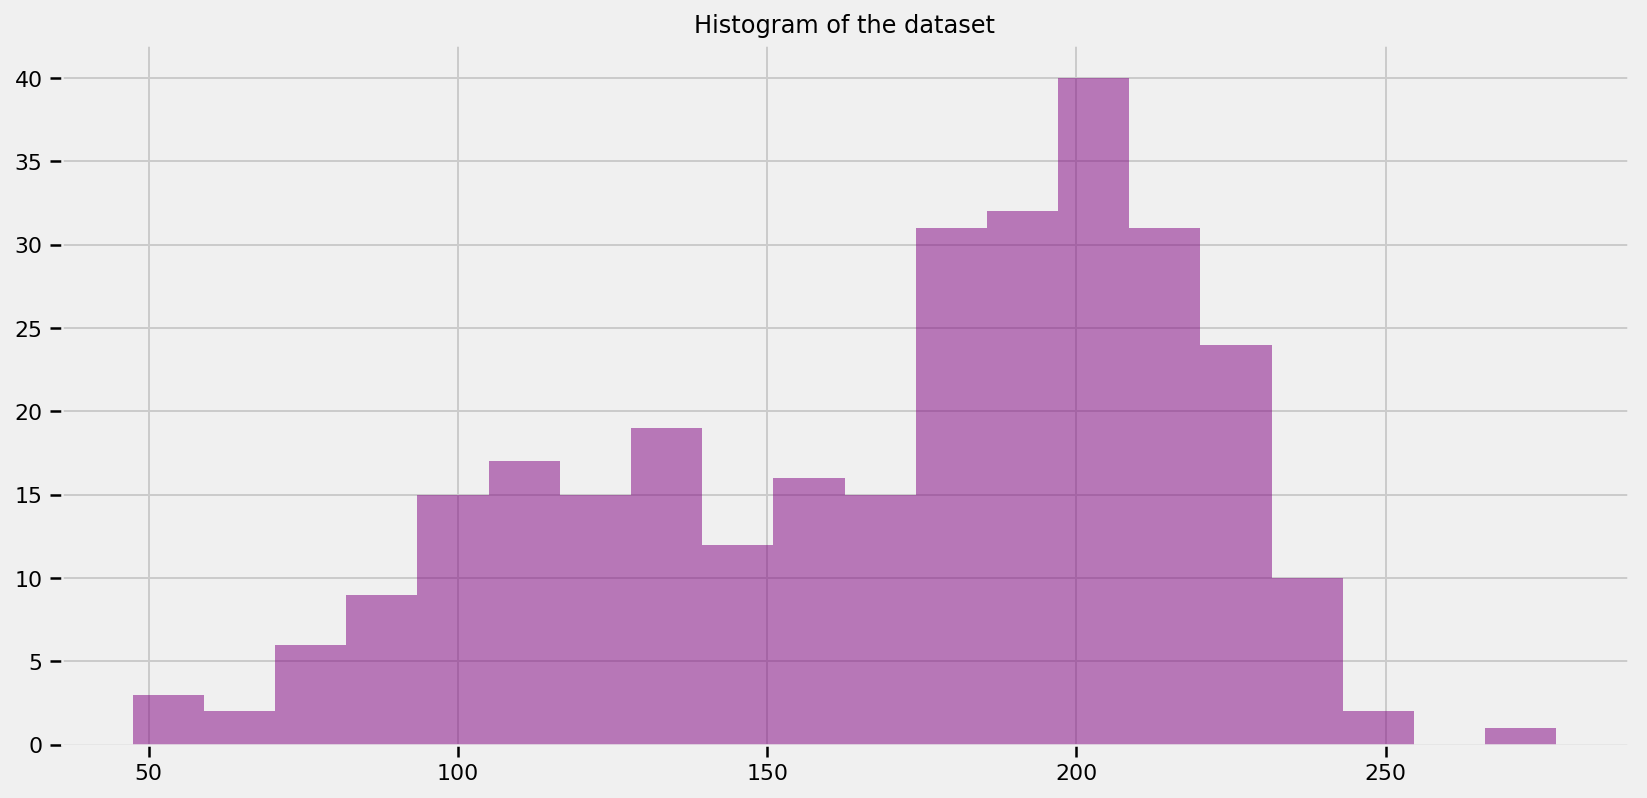

In [4]:
plt.figure(figsize(12.5, 6))
data_ = np.loadtxt("mixture_data.csv", delimiter=",")

plt.hist(data_, bins=20, color="purple", histtype="stepfilled", alpha=0.5)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
print(data_[:10], "...")

In [5]:
# We will use evaluate to show the value of tensor. 

p1 = tfd.Uniform(name='p', low=0., high=1.).sample() # Uniform.sample(n) = sample n samples based on uniform dist.
p2 = 1 - p1
p = tf.stack([p1, p2])
assignment = tfd.Categorical(name="assignment", probs=p)   
assignment_ = evaluate(assignment.sample(sample_shape=data_.shape[0], seed=42))[:10] # seed: Python integer to seed the random number generator.

print("prior assignment, with p = %.2f:" % evaluate(p1))
print("assigment evaluation: \n", assignment_)

prior assignment, with p = 0.51:
assigment evaluation: 
 [0 0 0 0 0 0 0 0 0 0]


In [6]:
rv_sds = tfd.Uniform(name="rv_sds", low=[0., 0.], high=[100., 100.])
rv_centers = tfd.Normal(name="rv_centers", loc=[120., 190.], scale=[10., 10.]) # loc = mean, scale = sd
    
center_i = rv_centers.sample()
sd_i = rv_sds.sample()

rv_assignments = tfd.Categorical(probs=tf.stack([0.4, 0.6])) #Stacks a list of rank-R tensors into one rank-(R+1) tensor.
assignment_ = evaluate(rv_assignments.sample(sample_shape=1000))

# and to combine it with the observations:
rv_observations = tfd.MixtureSameFamily(mixture_distribution = rv_assignments, components_distribution = tfd.Normal(loc = center_i, scale = sd_i))

sim_data_ = evaluate(rv_observations.sample(sample_shape=1000))

    
print("simulated data: ", sim_data_[0:10], "...")
print("Random assignments: ", assignment_[0:10], "...")
print("Assigned center: ", evaluate(center_i), "...")
print("Assigned standard deviation: ", evaluate(sd_i), "...")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
simulated data:  [127.851456 143.97118   80.29509  124.01346  208.59734  261.18262
  52.872353 268.4744   253.831    213.24376 ] ...
Random assignments:  [0 0 0 1 1 1 0 0 0 1] ...
Assigned center:  [104.82473 191.54266] ...
Assigned standard deviation:  [65.534485 73.49317 ] ...


## Visualization 1

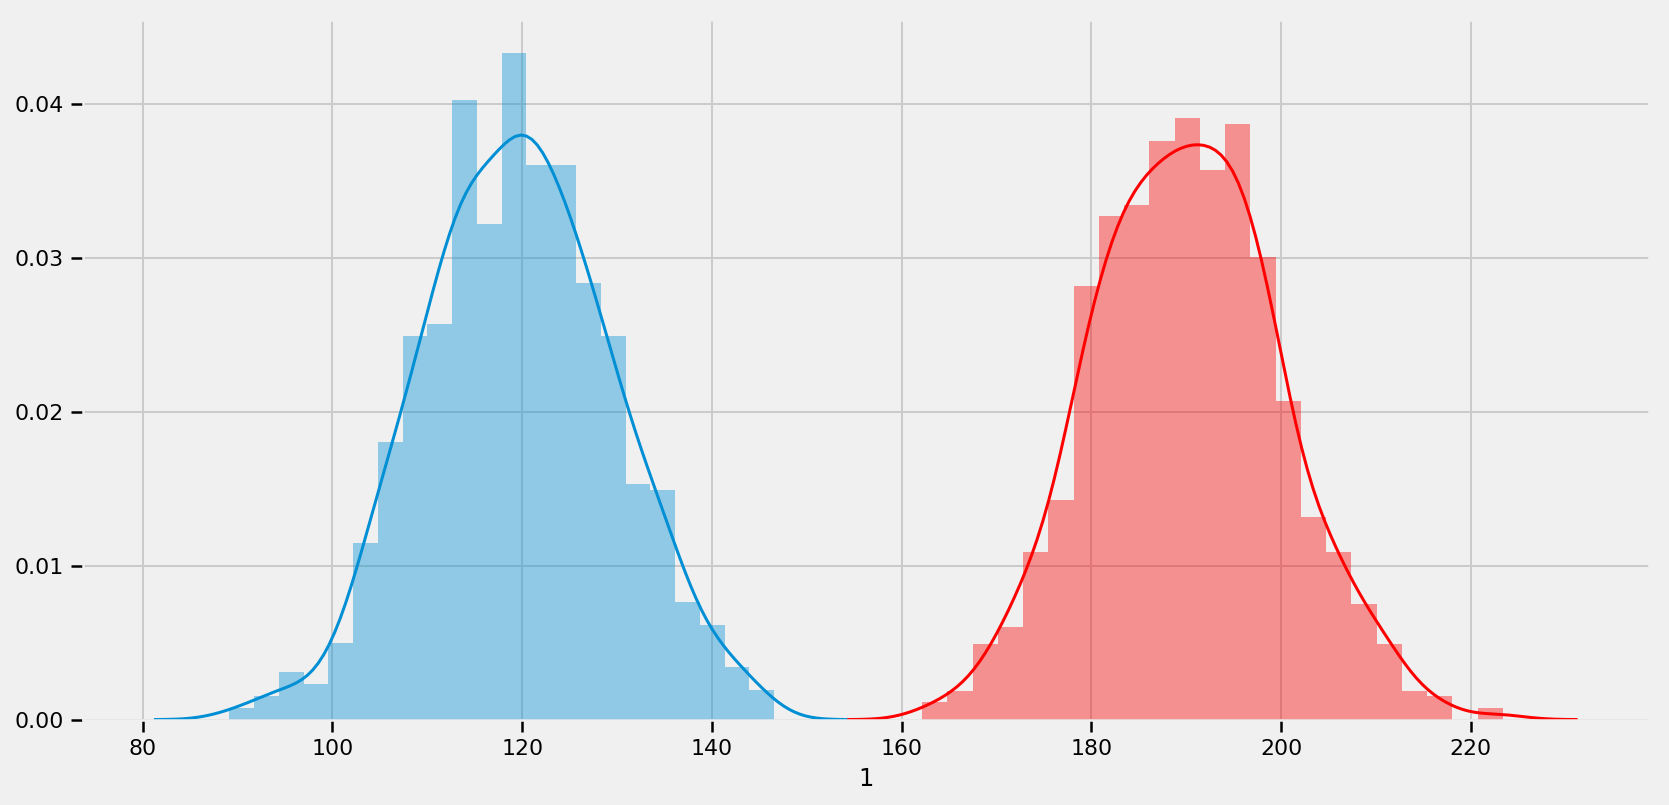

In [7]:
df_center_i = pd.DataFrame(evaluate(rv_centers.sample(sample_shape=1000)))
sns.distplot(df_center_i[0])
sns.distplot(df_center_i[1], color ='r')
plt.show()

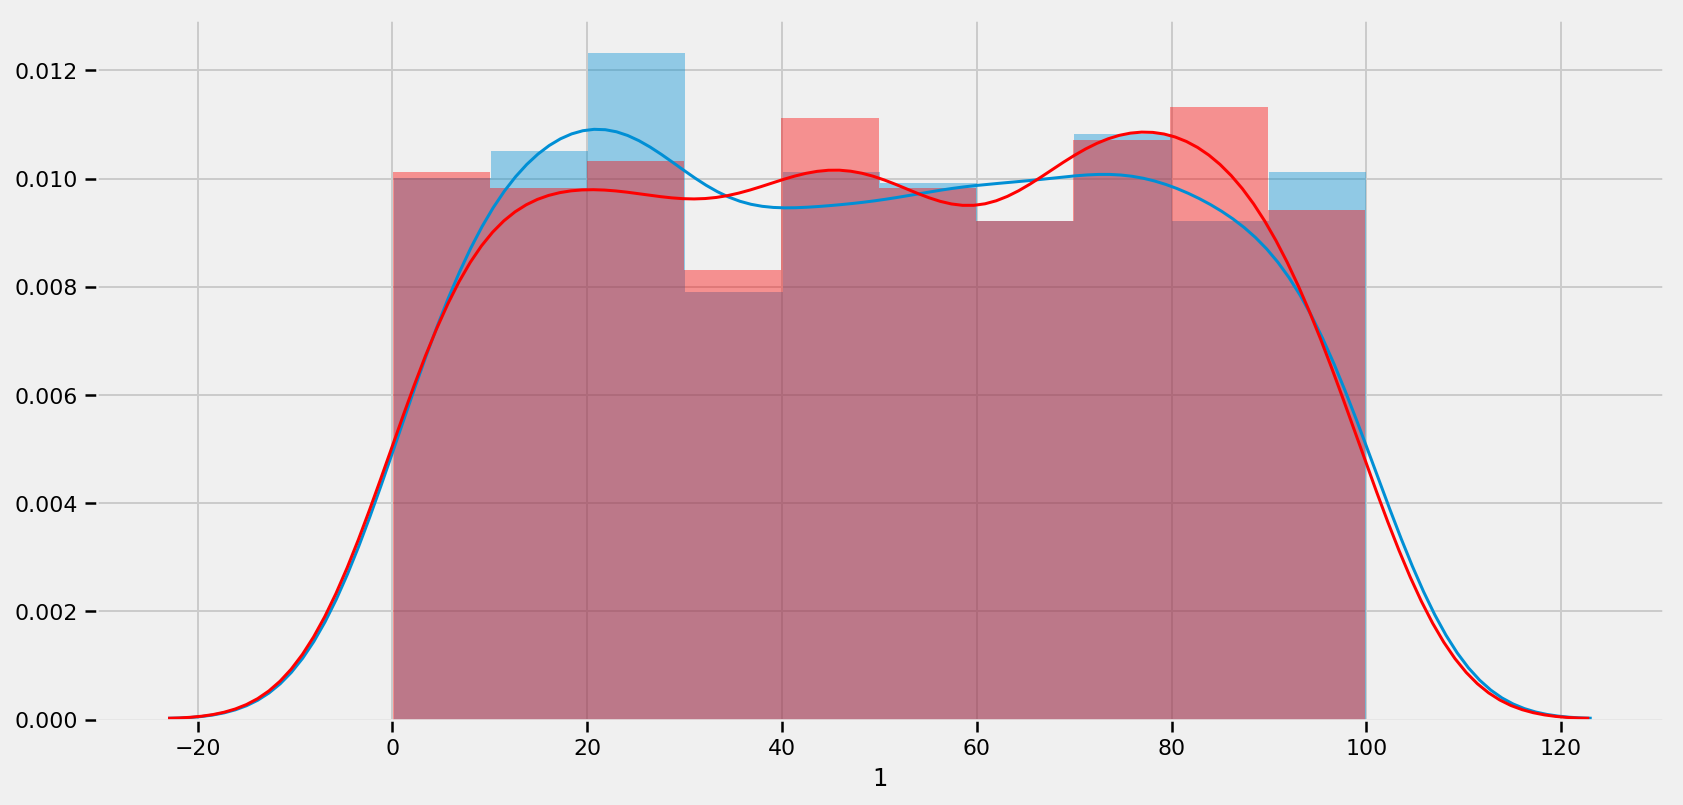

In [8]:
df_sd_i = pd.DataFrame(evaluate(rv_sds.sample(sample_shape=1000)))
sns.distplot(df_sd_i[0])
sns.distplot(df_sd_i[1], color ='r')
plt.show()

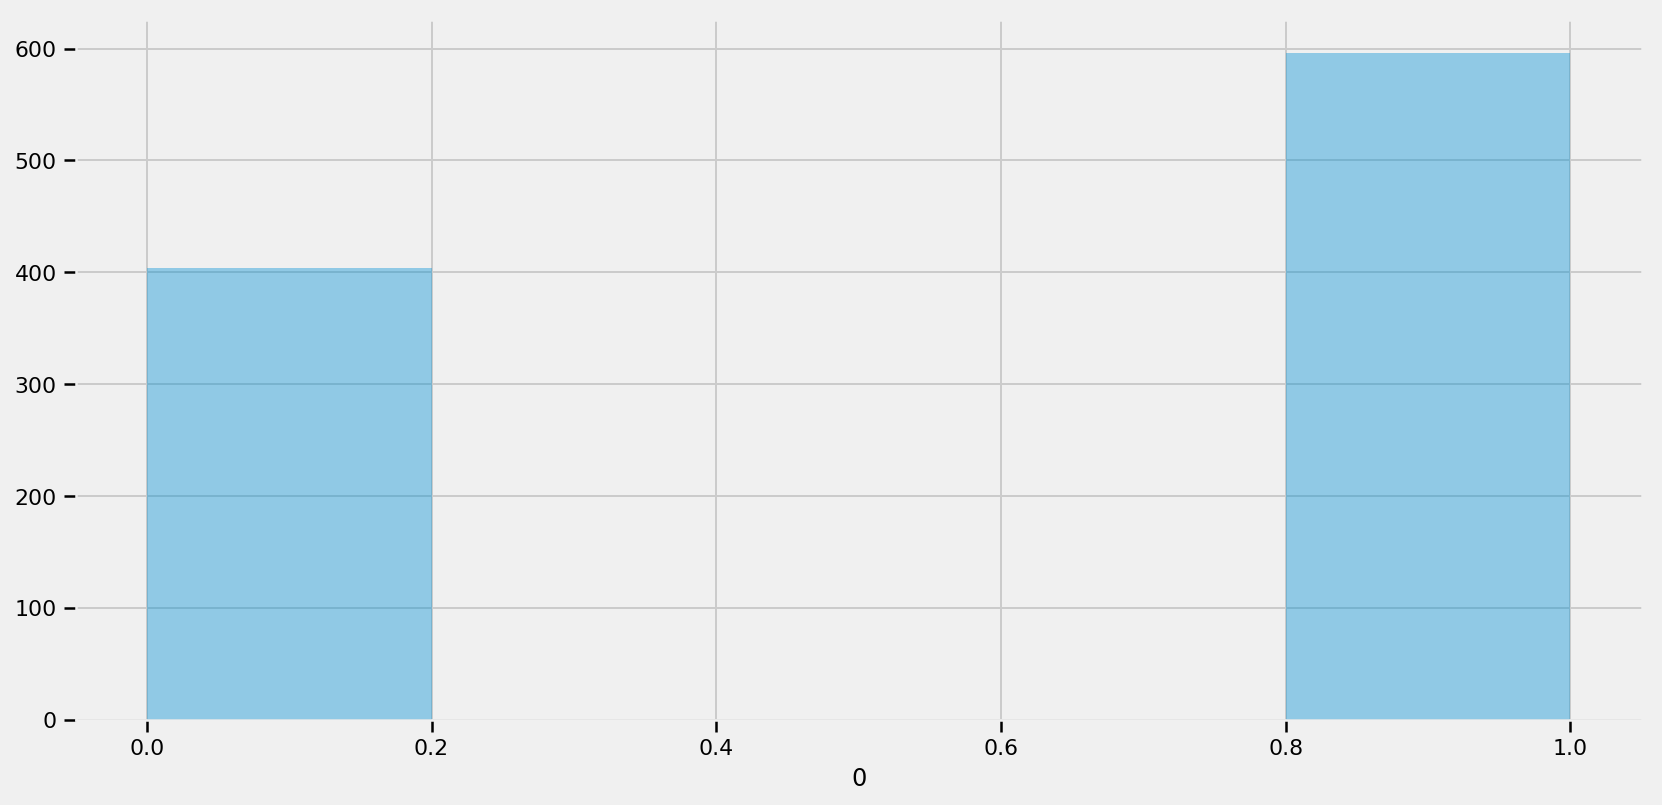

In [9]:
df_ass = pd.DataFrame(assignment_)
sns.distplot(df_ass[0], kde = False)
# sns.distplot(df_ass[1], color ='r')
plt.show()

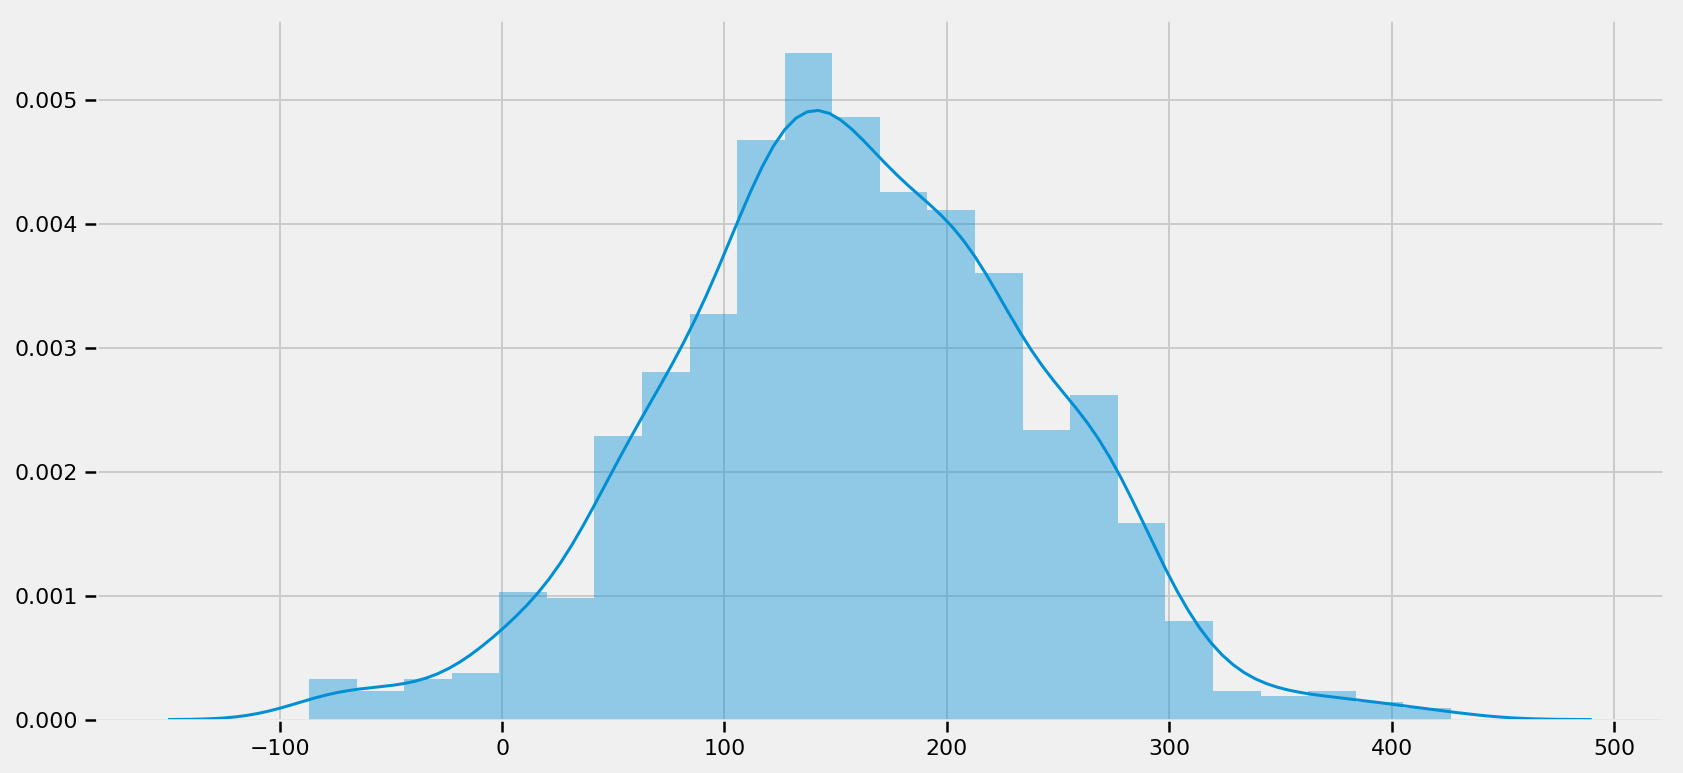

In [10]:
sns.distplot(sim_data_)

## Process  : joint prob

In [0]:
def joint_log_prob(data_, sample_prob_1, sample_centers, sample_sds):
    """
    Joint log probability optimization function.
        
    Args:
      - data: tensor array representation of original data
      - sample_prob_1: Scalar representing probability (out of 1.0) of assignment being 0
      - sample_sds: 2d vector containing standard deviations for both normal dists in model
      - sample_centers: 2d vector containing centers for both normal dists in model
    
    Returns: 
      Joint log probability optimization function.
    """  
    
    ### Create a mixture of two scalar Gaussians:
    rv_prob = tfd.Uniform(name='rv_prob', low=0., high=1.)
    sample_prob_2 = 1. - sample_prob_1
    rv_assignments = tfd.Categorical(probs=tf.stack([sample_prob_1, sample_prob_2]))
    rv_sds = tfd.Uniform(name="rv_sds", low=[0., 0.], high=[100., 100.])
    rv_centers = tfd.Normal(name="rv_centers", loc=[120., 190.], scale=[10., 10.])
    
    rv_observations = tfd.MixtureSameFamily(mixture_distribution = rv_assignments,
                                            components_distribution = tfd.Normal(loc = sample_centers,       # One for each component.
                                                                                 scale = sample_sds))        # And same here.
    return (
        rv_prob.log_prob(sample_prob_1) # Log probability density/mass function.
        + rv_prob.log_prob(sample_prob_2)
        + tf.reduce_sum(rv_observations.log_prob(data_))      # Sum over samples.
        + tf.reduce_sum(rv_centers.log_prob(sample_centers)) # Sum over components.
        + tf.reduce_sum(rv_sds.log_prob(sample_sds))         # Sum over components.
    )
    sum_log_prob = tf.reduce_sum(tf.concat(log_prob_parts, axis=-1), axis=-1) #.log_prob_parts gives the log_prob of each nodes in the Graphical model
    # Note: for easy debugging, uncomment the following:
    
    return sum_log_prob

In [0]:
number_of_steps = 5000
burnin = 5000

# Set the chain's start state.
initial_chain_state = [
    tf.constant(0.5, name='init_probs'),
    tf.constant([120., 190.], name='init_centers'),
    tf.constant([10., 10.], name='init_sds')
]

# Since MCMC operates over unconstrained space, 
# we need to transform the samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Identity(),       # Maps R to R.
    tfp.bijectors.Identity(),       # Maps R to R.
    tfp.bijectors.Identity(),       # Maps R to R.
]

# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: joint_log_prob(data_, *args)


# Initialize the step_size. (It will be automatically adapted.)
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer = tf.constant(0.1, dtype=tf.float32), 
        trainable=False, # If True also add the variable to the graph collection GraphKeys.TRAINABLE_VARIABLES
        use_resource=True)

##<font color = pink> Hamiltonian Monte Carlo algorithm </font>
(originally known as hybrid Monte Carlo), 
is a Markov chain Monte Carlo method for obtaining a sequence of random samples from a probability distribution for which direct sampling is difficult. This sequence can be used to approximate the distribution (i.e., to generate a histogram)

https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo

In [13]:
# Defining HMC option (TransitionKernel steps)
# if you executed and got an error at the second time. just skip this part. In other word, we can execute only at once.

hmc = tfp.mcmc.TransformedTransitionKernel( # Markov chain Monte Carlo (MCMC) transition kernel. A transition kernel returns a new state given some old state.
    inner_kernel = tfp.mcmc.HamiltonianMonteCarlo( # Hamiltonian Monte Carlo (HMC) is a Markov chain Monte Carlo (MCMC) algorithm that takes a series of gradient-informed steps to produce a Metropolis proposal. This class implements one random HMC step from a given current_state
        target_log_prob_fn = unnormalized_posterior_log_prob, # current_state
        num_leapfrog_steps = 2,
        step_size = step_size,
        step_size_update_fn = tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=int(burnin * 0.1)), # like learning rate
        state_gradients_are_stopped = True), # TRUE, calculate the grediet to find the optimal solution
        bijector = unconstraining_bijectors) # mapping fuction from N dimension to 2D



Instructions for updating:
Use tfp.mcmc.SimpleStepSizeAdaptation instead.
Instructions for updating:
The `step_size_update_fn` argument is deprecated. Use `tfp.mcmc.SimpleStepSizeAdaptation` instead.


In [0]:
# Sample from the chain. (Implements Markov chain Monte Carlo via repeated TransitionKernel steps)
#number_of_steps = 13000 , burnin = 1000
[
    posterior_prob, 
    posterior_centers, 
    posterior_sds
], kernel_results = tfp.mcmc.sample_chain(num_results = number_of_steps, 
                                       num_burnin_steps = burnin, 
                                       current_state = initial_chain_state, 
                                       kernel = hmc)

# Initialize any created variables.
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

In [15]:
evaluate(init_g)
evaluate(init_l)

[
    posterior_prob_,
    posterior_centers_,
    posterior_sds_,
    kernel_results_
] = evaluate([
    posterior_prob,
    posterior_centers,
    posterior_sds,
    kernel_results
])
    
new_step_size_initializer_ = kernel_results_.inner_results.is_accepted.mean()
print("acceptance rate: {}".format(new_step_size_initializer_))
# new_step_size_initializer_
#print("final step size: {}".format(kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))

acceptance rate: 0.7058


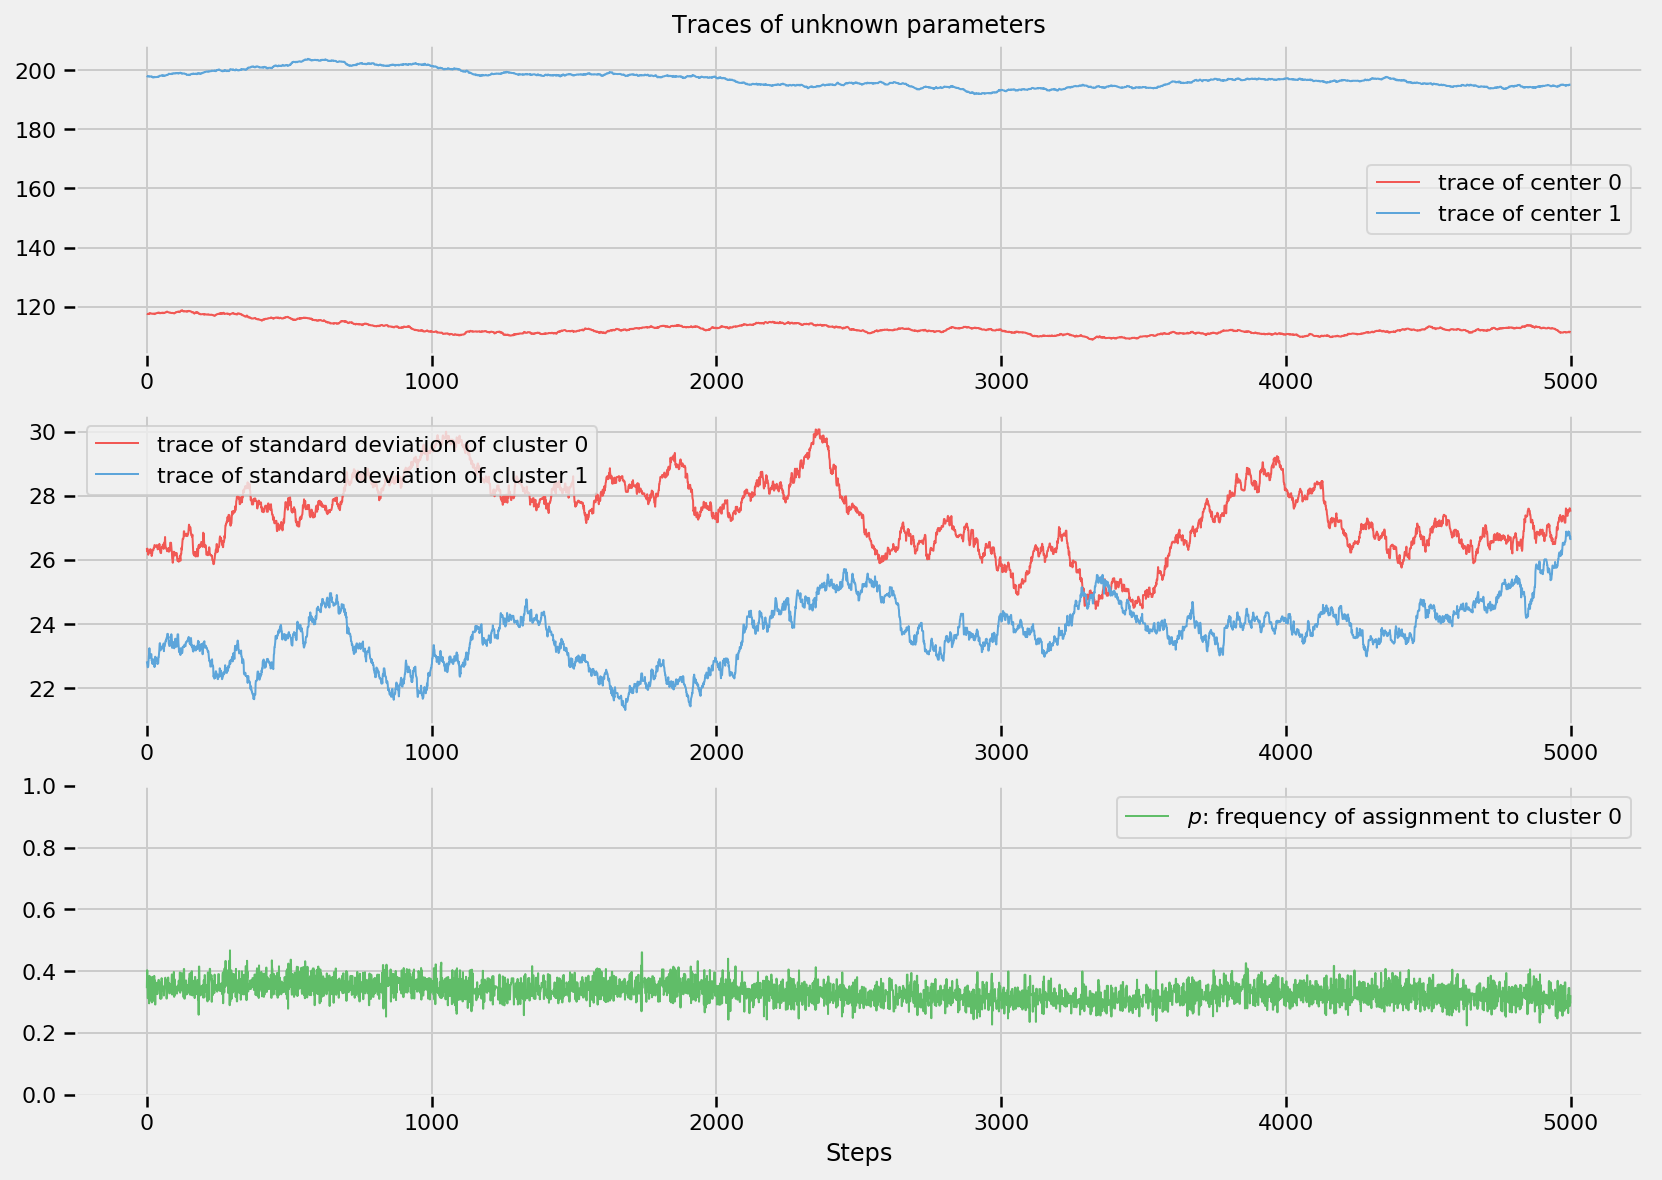

In [16]:
plt.figure(figsize(12.5, 9))
lw = 1
start = 1000 # for plot a graph below

center_trace = posterior_centers_ # Update mu
std_trace = posterior_sds_ # Update sd
p_trace = posterior_prob_ # update prob
colors = [TFColor[3], TFColor[0]] if center_trace[-1, 0] > center_trace[-1, 1] else [TFColor[0], TFColor[3]]

# ----------------------- mu(expectation) ----------------------------------- #

plt.subplot(311)
plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters") # sample value
leg = plt.legend(loc="center right")
leg.get_frame().set_alpha(0.7)

# ----------------------- SD ------------------------------------------- #

plt.subplot(312)
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

# ----------- Prob of sample likely belong to Cluster 0 -------------------- #
# for Cluster 1; 1 - P(sample belong to Cluster 0)
plt.subplot(313)
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=TFColor[2], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();

In [0]:
# len(center_trace[start:number_of_steps,0]), center_trace[start:number_of_steps,0],\
# len(center_trace[start:number_of_steps,1]), center_trace[start:number_of_steps,1]

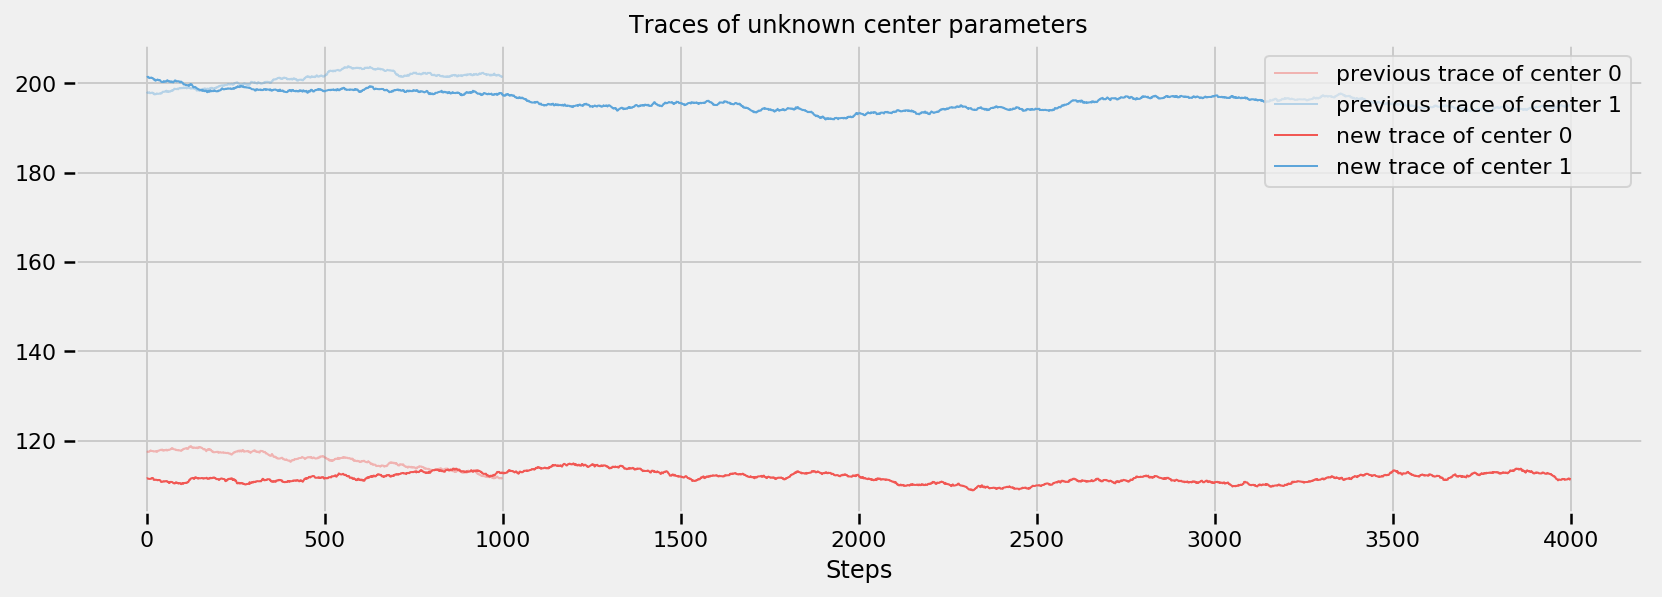

In [18]:
plt.figure(figsize(12.5, 4))
new_center_trace0 = center_trace[start:number_of_steps,0]
new_center_trace1 = center_trace[start:number_of_steps,1]

plt.plot(center_trace[:start, 0], label="previous trace of center 0", lw=lw, alpha=0.4, c="#F15854")
plt.plot(center_trace[:start, 1], label="previous trace of center 1", lw=lw, alpha=0.4, c="#5DA5DA")

# --------------------------- Main line --------------------------------------
plt.plot(new_center_trace0 , label="new trace of center 0", lw=lw, c="#F15854")
plt.plot(new_center_trace1 , label="new trace of center 1", lw=lw, c="#5DA5DA")

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");

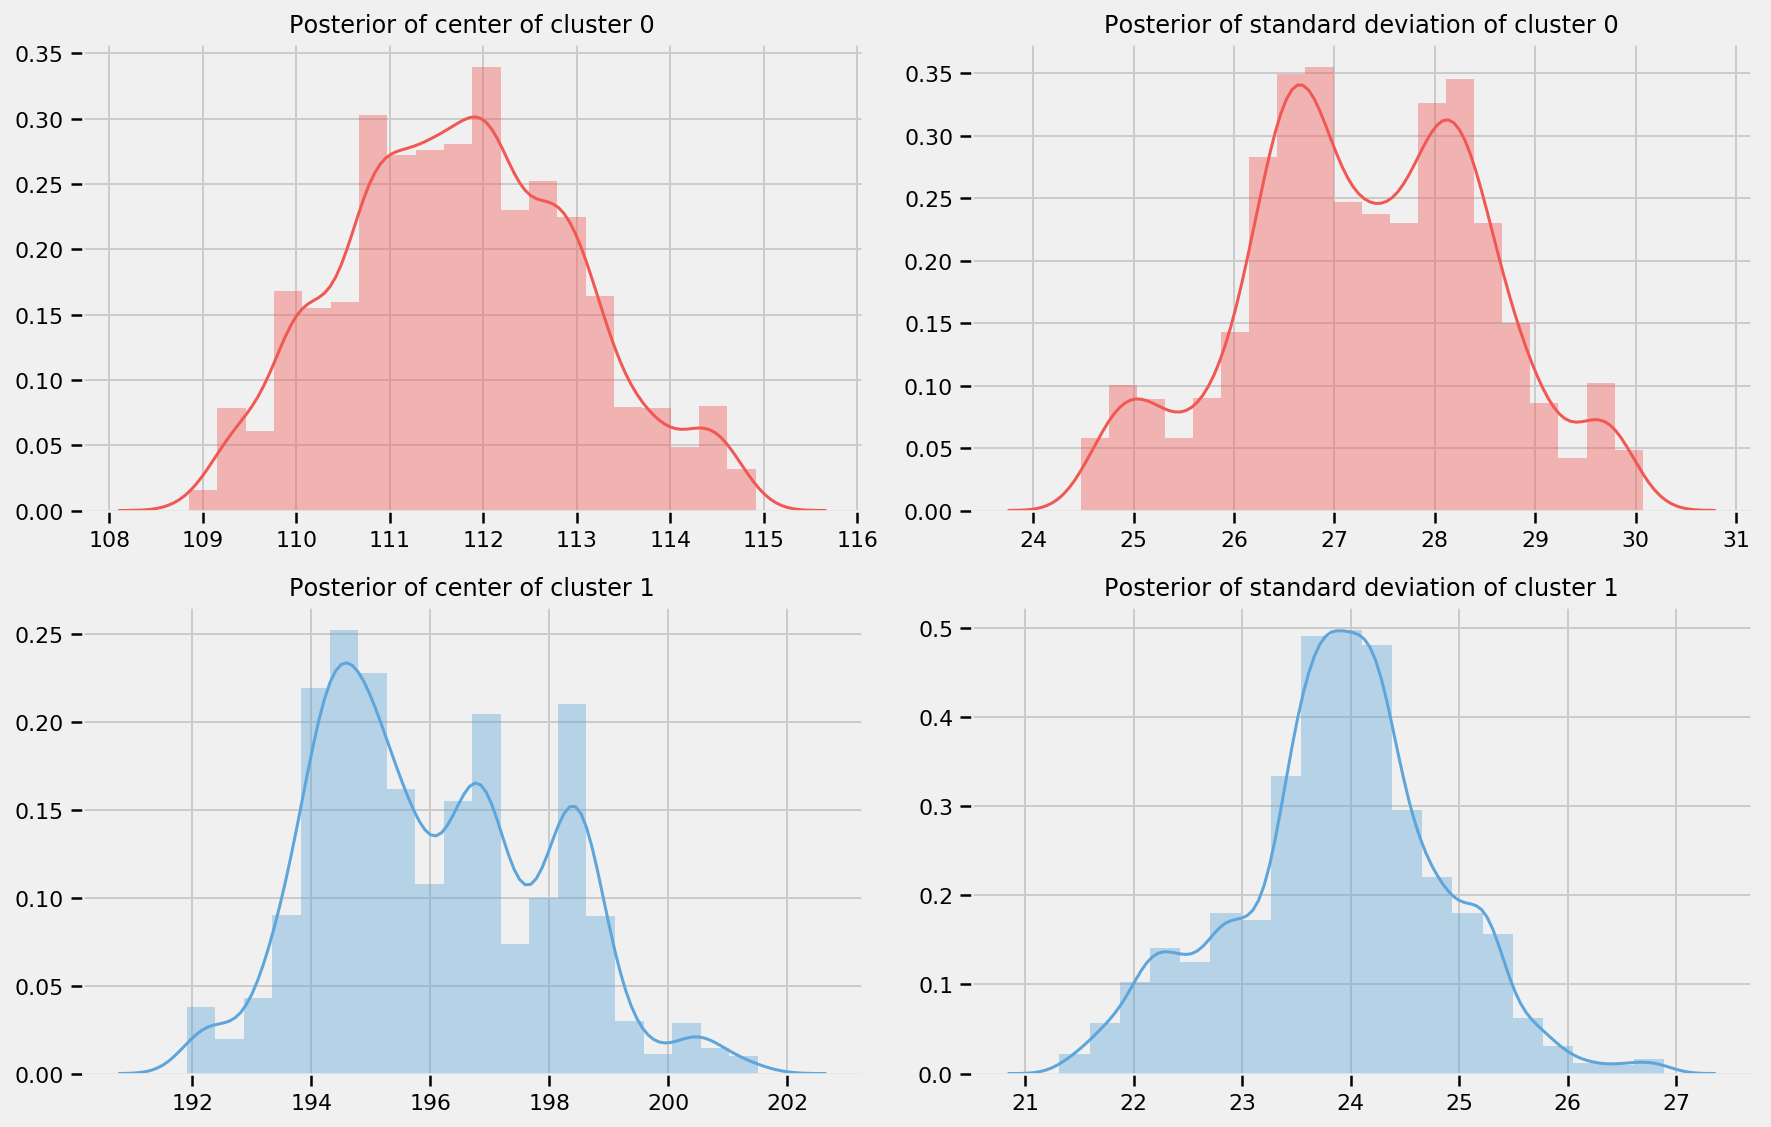

In [19]:
plt.figure(figsize(12.5, 8))
std_trace = posterior_sds_
prev_std_trace = posterior_sds_

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    #plt.hist(center_trace[start:number_of_steps, i], color=colors[i], bins=20, histtype="stepfilled")
    sns.distplot(center_trace[start:number_of_steps, i], color=colors[i], bins=20)
    
    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    #plt.hist(std_trace[start:number_of_steps, i], color=colors[i], bins=20, histtype="stepfilled")
    sns.distplot(std_trace[start:number_of_steps, i], color=colors[i], bins=20)
    # plt.autoscale(tight=True)

plt.tight_layout()

In [20]:
import matplotlib as mpl

# data_ = np.loadtxt("mixture_data.csv", delimiter=",")
plt.figure(figsize(12.5, 5))

posterior_center_means = evaluate(tf.reduce_mean(posterior_centers_, axis=0))
posterior_std_means = evaluate(tf.reduce_mean(posterior_sds_, axis=0))
posterior_prob_mean = evaluate(tf.reduce_mean(posterior_prob_, axis=0))

dist_0 = tfd.Normal(loc=posterior_center_means[0], scale=posterior_std_means[0])
dist_1 = tfd.Normal(loc=posterior_center_means[1], scale=posterior_std_means[1])

prob_assignment_0 = dist_0.prob(data_)
prob_assignment_1 = dist_1.prob(data_)

probs_assignments = tf.subtract(1., tf.div(prob_assignment_1, tf.add_n([prob_assignment_0, prob_assignment_1])))

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


<Figure size 900x360 with 0 Axes>

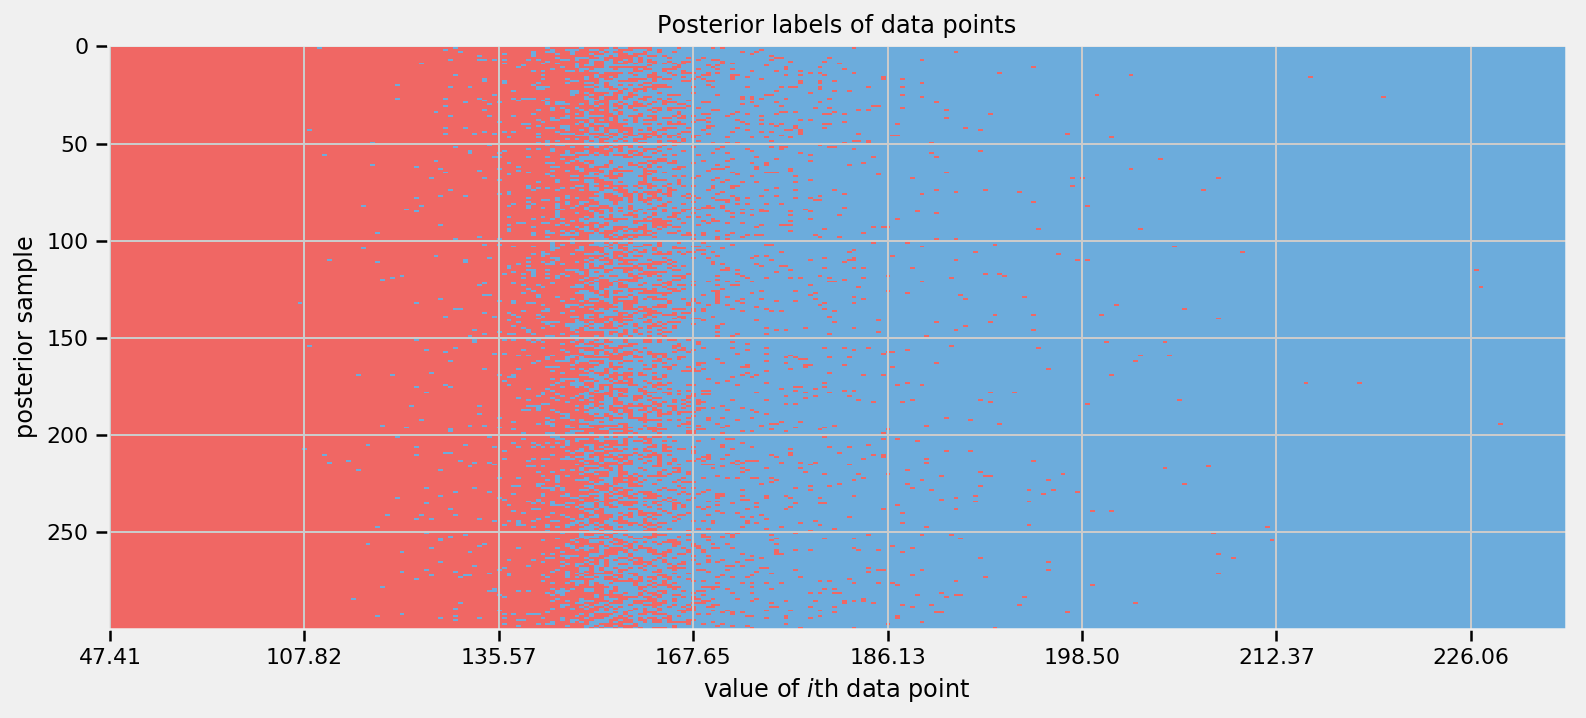

In [21]:
probs_assignments_inv = tf.subtract(1., probs_assignments)
cluster_probs = tf.transpose(tf.stack([probs_assignments, probs_assignments_inv]))

burned_assignment_trace_ = evaluate(tfd.Categorical(probs=cluster_probs).sample(sample_shape=300))

plt.figure(figsize(12.5, 5))
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(burned_assignment_trace_[:, np.argsort(data_)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data_.shape[0], 40),
       ["%.2f" % s for s in np.sort(data_)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");

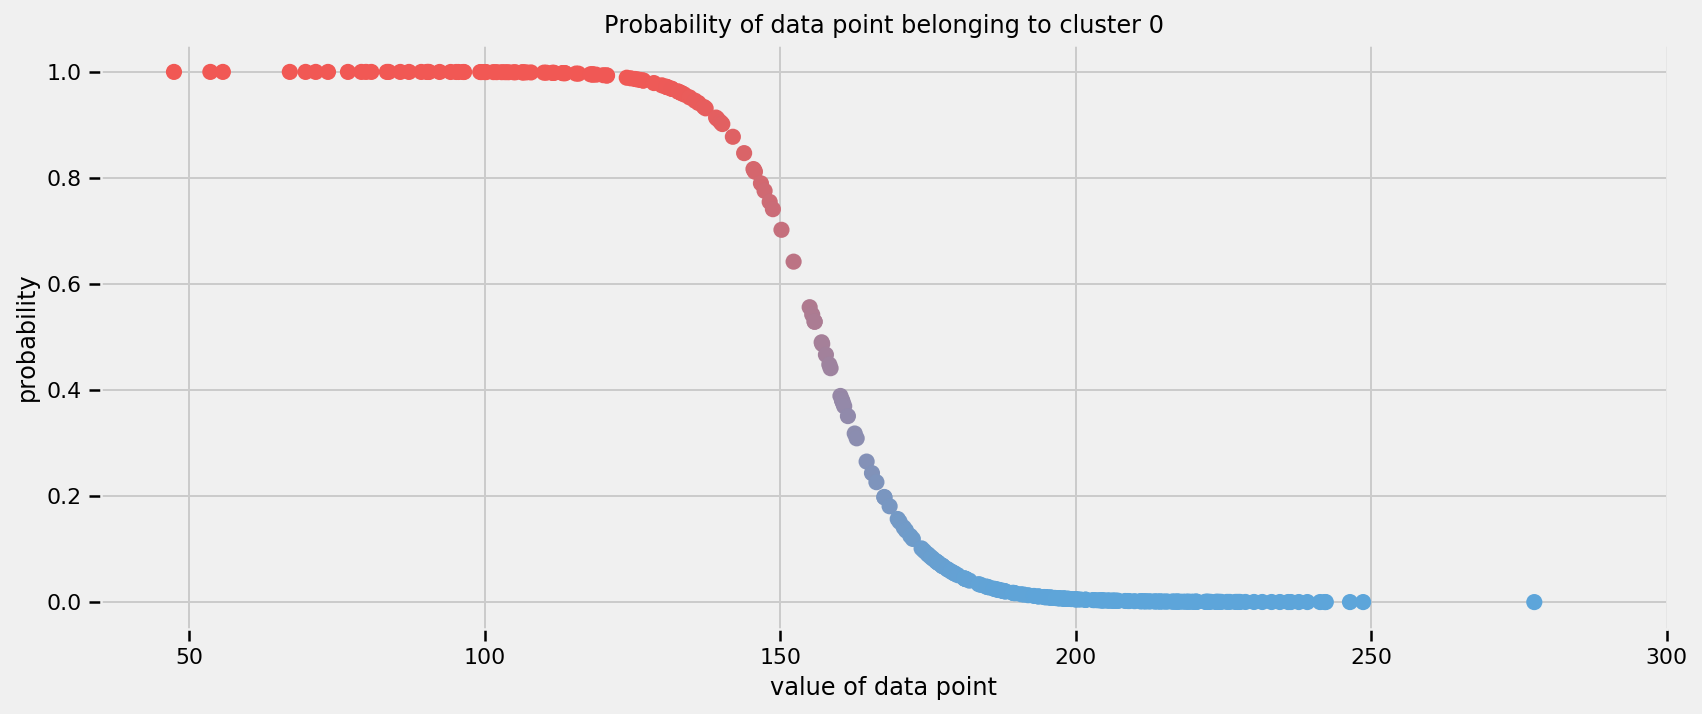

In [22]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = evaluate(probs_assignments)[np.argsort(data_)]
plt.scatter(data_[np.argsort(data_)], assign_trace, cmap=cmap,
        c=(1 - assign_trace), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point");

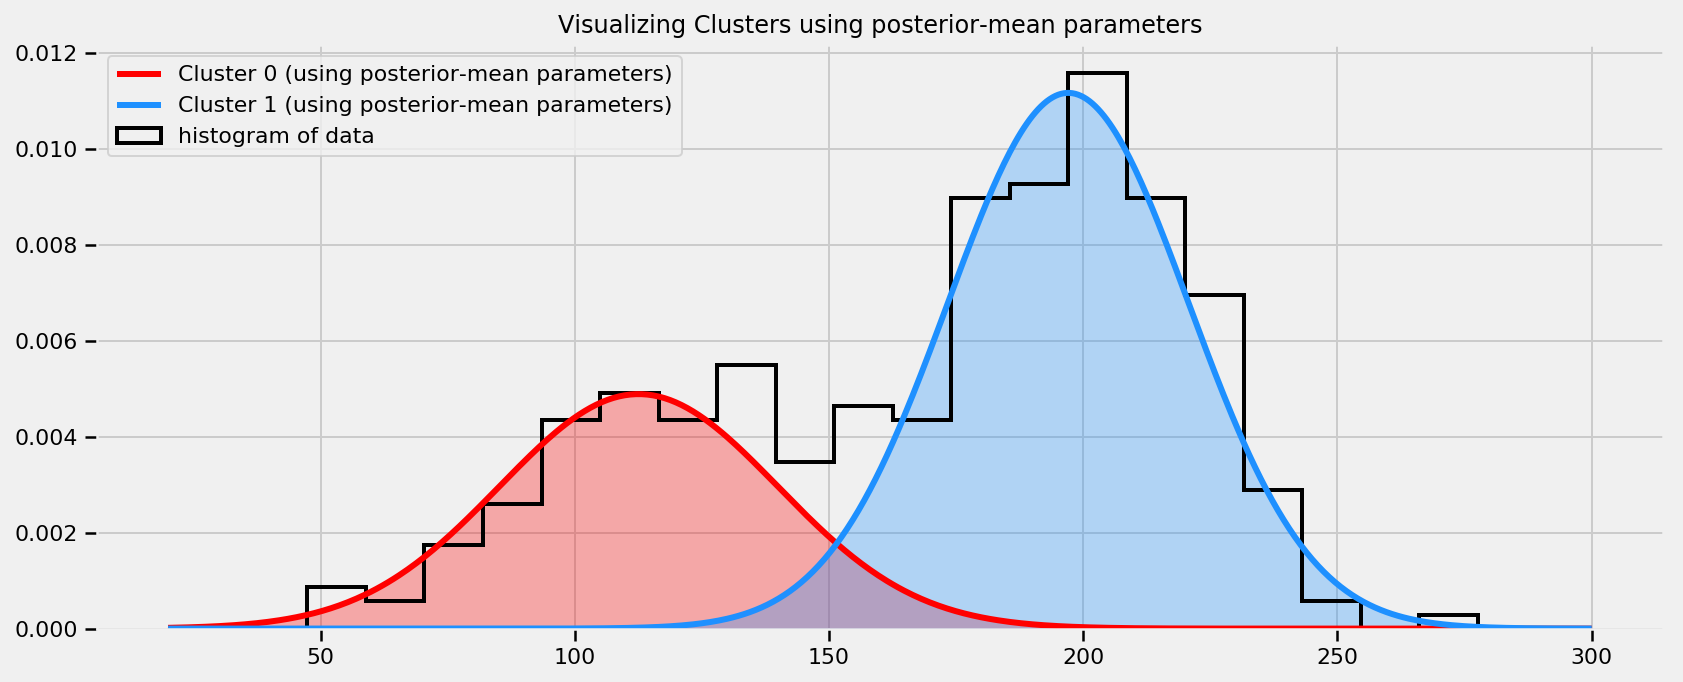

In [23]:
x_ = np.linspace(20, 300, 500)
plt.title("Visualizing Clusters using posterior-mean parameters");


posterior_center_means = evaluate(tf.reduce_mean(posterior_centers_, axis=0)) # Find average of Posterior
posterior_std_means = evaluate(tf.reduce_mean(posterior_sds_, axis=0))        # Find average of Posterior SD
posterior_prob_mean = evaluate(tf.reduce_mean(posterior_prob_, axis=0))       # Find average of posterior Prob


# Use Post-Prob * normal distribution of mean of Post-SD and Post-mean
plt.hist(data_, bins=20, histtype="step", normed=True, color="k", lw=2, label="histogram of data")


y_ = posterior_prob_mean * evaluate(tfd.Normal(loc=posterior_center_means[0], scale=posterior_std_means[0]).prob(x_))
plt.plot(x_, y_, label="Cluster 0 (using posterior-mean parameters)", lw=3, color = 'red')
plt.fill_between(x_, y_, color = 'red', alpha=0.3)


y_ = (1 - posterior_prob_mean) * evaluate(tfd.Normal(loc=posterior_center_means[1], scale=posterior_std_means[1]).prob(x_))
plt.plot(x_, y_, label="Cluster 1 (using posterior-mean parameters)", lw = 3, color ='dodgerblue' )
plt.fill_between(x_, y_, color = 'dodgerblue', alpha=0.3)


plt.legend(loc="upper left")



In [24]:
print("acceptance rate: {}".format(new_step_size_initializer_))
print('Mean of posterior: {}'.format(posterior_center_means))
print('SD of posterior: {}'.format(posterior_std_means))

acceptance rate: 0.7058
Mean of posterior: [112.54214 197.03798]
SD of posterior: [27.364737 23.727577]
